# Figure 1: feature extraction methods

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("paper", "white")
from pyns import Neuroscout
import math

api = Neuroscout()

In Figure 1, we plot the timeseries of three example `Predictors`: `any_faces` (binary indicator of face presence), `building` (probability of building in frame), `subtlexusfrequency_Lg10WF` (frequency norm for each word in the speech transcript).

### 1) First, identify an example  run associated with the "SherlockMerlin" dataset and "MerlinMovie" task

First, let's take a look at the available datasets in Neuroscout

In [2]:
datasets = api.datasets.get()
print(f'dataset count = {len(api.datasets.get())}\n')
print('Datasets and IDs:\n')
for i in datasets:
    print(i['name'], i['id'])

dataset count = 12

Datasets and IDs:

studyforrest 11
Raiders 10
SchematicNarrative 20
SherlockMerlin 5
Sherlock 21
narratives 30
Life 9
ParanoiaStory 18
LearningTemporalStructure 19
Budapest 27
NaturalisticNeuroimagingDatabase 28
ReadingBrainProject 29


For this Figure, we are going to focus on the "SherlockMerlin" dataset, task "MerlinMovie".

Although all the subjects saw the same movie in this task, we need to ask for the timeline of a specific subject / run in Neuroscout (as it is designed to allow for different stimuli per run/subject).

In [3]:
# See tasks for SherlockMerlin dataset. Notice "MerlinMovie" has task "id": 4
api.datasets.get(5)['tasks']

[{'TR': 1.5,
  'avg_run_duration': 1543,
  'id': 4,
  'n_runs_subject': 1,
  'n_subjects': 18,
  'name': 'MerlinMovie',
  'summary': 'AV Presentation: Merlin Episode'},
 {'TR': 1.5,
  'avg_run_duration': 1475,
  'id': 45,
  'n_runs_subject': 1,
  'n_subjects': 18,
  'name': 'SherlockMovie',
  'summary': 'AV Presentation: Sherlock Episode'}]

In [4]:
# Get any run (first) associated with task "MerlinMovie", id == "4"
api.runs.get(task_id=4)[0]

{'acquisition': None,
 'dataset_id': 5,
 'duration': 1543.5,
 'id': 1410,
 'number': None,
 'session': None,
 'subject': '25',
 'task': 4,
 'task_name': 'MerlinMovie'}

In [5]:
# Save the run number an duration for that run
run_id = api.runs.get(task_id=4)[0]['id']
run_duration = api.runs.get(task_id=4)[0]['duration']

### 2) For predictors of interest, extract timeseries 

Here, for the predictors `any_faces`, `building`, and `subtlexusfrequency_Lg10WF`, we will extract predictor events for this specific run (subject: 25, task: 'MerlinMovie'). 

First, we need to get the `predictor_id` for each predictor of interest associated with that specific run. 

<div class="alert alert-block alert-info">
<b>Note:</b> In Neuroscout, `predictor_ids` are different for each dataset even for the same named features (e.g. "any_faces"). Within Datasets, they can also differ for each task. For that reason, it's safest to ask for the Predictor ID associated with a specific run, or sets of runs. 
</div>

In [8]:
api.predictors.get(name='any_faces', run_id=run_id)

[{'dataset_id': 5,
  'description': 'Binary indicator of face detection',
  'id': 19921,
  'max': 1.0,
  'mean': 1.0,
  'min': 1.0,
  'name': 'any_faces',
  'num_na': 0,
  'private': False,
  'source': 'Collection: merlin_facenet_cw_min50_t62'}]

In [10]:
any_faces_predictor_id = api.predictors.get(name='any_faces', run_id=run_id)[0]['id']

We can then query `predictor_events` to get all of the recorded events for this predictor, for a given run:

In [23]:
# First 3 events for "any_faces" for an example run 
api.predictor_events.get(predictor_id=any_faces_predictor_id, run_id=run_id)[0:3]

[{'duration': 1.0,
  'onset': 68.5,
  'predictor_id': 19921,
  'run_id': 1410,
  'stimulus_id': None,
  'value': '1.0'},
 {'duration': 1.0,
  'onset': 69.5,
  'predictor_id': 19921,
  'run_id': 1410,
  'stimulus_id': None,
  'value': '1.0'},
 {'duration': 1.0,
  'onset': 70.5,
  'predictor_id': 19921,
  'run_id': 1410,
  'stimulus_id': None,
  'value': '1.0'}]

Notice that events are in "sparse" (or 3 column EV) format, with the keys "onset" "duration" and "value".
Time points with no value, do not receive an explicit events. 

In order to plot these events together, we need to convert them into fixed timing evenly sampled format:

In [25]:
all_data = []
for feat in ['any_faces','building','subtlexusfrequency_Lg10WF']:
    predictor_id = api.predictors.get(name=feat, run_id=run_id)[0]['id']
    an_event = api.predictor_events.get(
        predictor_id = predictor_id,
        run_id=run_id,
        stimulus_timing=True)
    
    data = np.zeros((int(run_duration*100)))
    for i in an_event:
        start = round(i['onset']*100)

        stop = start + math.ceil(i['duration']*100)
        value = i['value']
        try:
            data[start:stop]=value
        except:
            pass
    data = data[2500:]
    all_data.append(data)

### 3) Plot timecourse in two sample windows

Finally, we use some custom matplotlib code to plot the timecourse of these three predictor in two windows of the the movie. 

`Figure 1` was hand customized to create the final figure. 

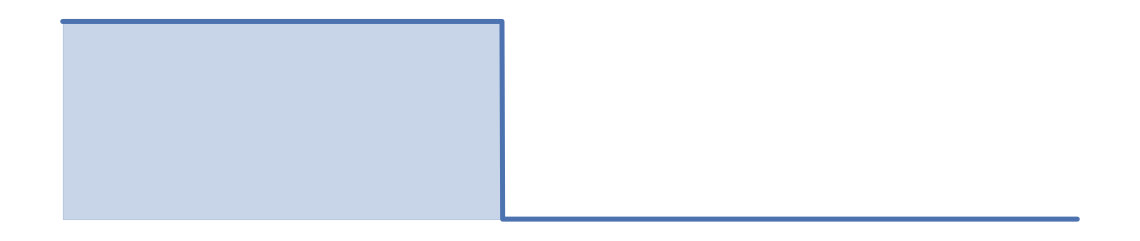

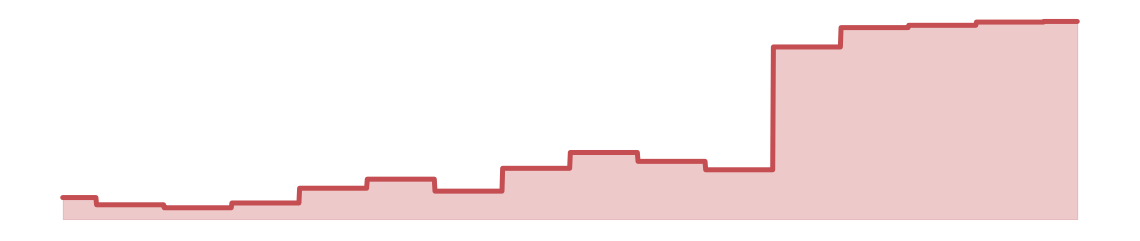

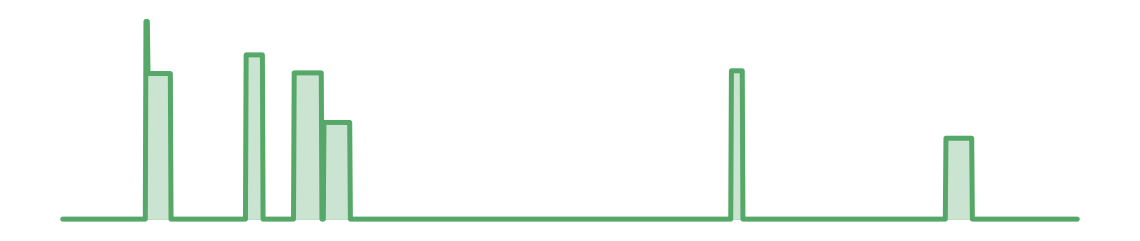

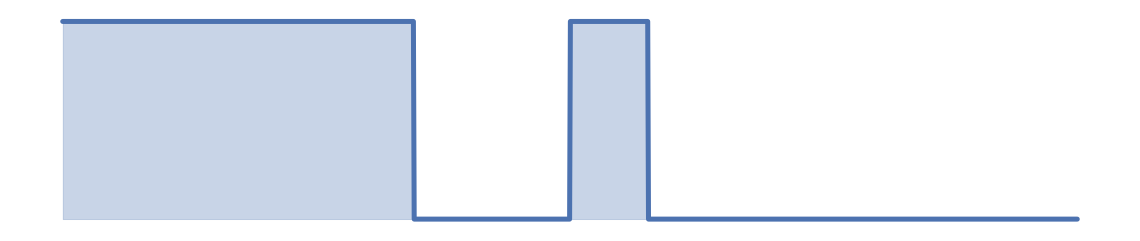

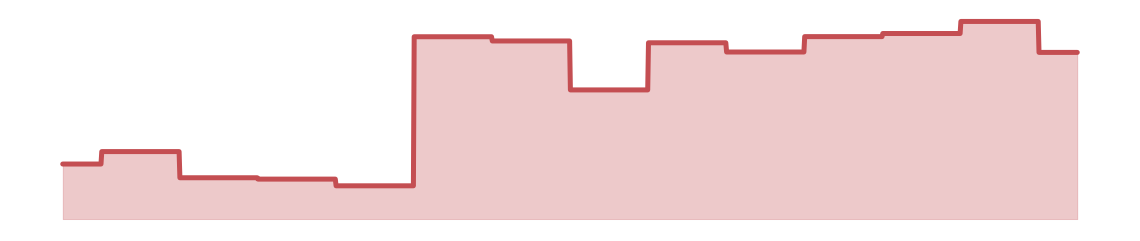

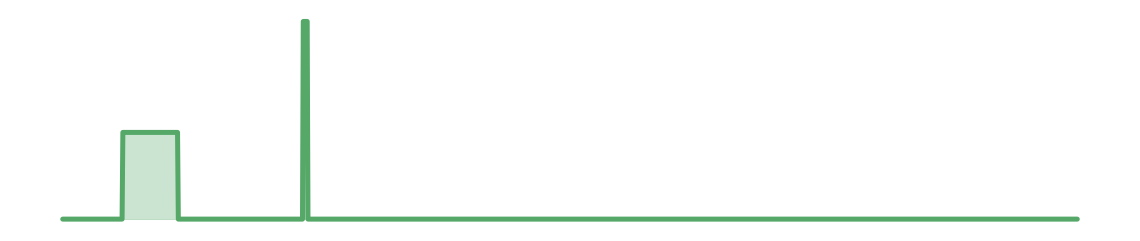

In [27]:
all_data_y = np.arange(int(all_data[1].shape[0]))
# ind1=8000
# ind2=9000
ind1=7500
ind2=9000
for i,color in enumerate(['b','r','g']):
    plt.figure(figsize=(20, 4))
    plt.plot(all_data_y[ind1:ind2],all_data[i][ind1:ind2], linewidth=5,c=color)
    plt.fill_between(all_data_y[ind1:ind2],all_data[i][ind1:ind2],color=color,alpha=0.3)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    frame1.axes.axis('off')
ind1=128000
ind2=129300

# ind1=103500
# ind2=105000
for i,color in enumerate(['b','r','g']):
    plt.figure(figsize=(20, 4))
    plt.plot(all_data_y[ind1:ind2],all_data[i][ind1:ind2], linewidth=5,c=color)
    plt.fill_between(all_data_y[ind1:ind2],all_data[i][ind1:ind2],color=color,alpha=0.3)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    frame1.axes.axis('off')